In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import log
from datetime import datetime as dt

from _data.database import Database

In [23]:
sec = json.load(open('_data/data_specs.json'))

In [3]:
db = database(sec, 1).data

Retrieving data from Yahoo Finance...
[*********************100%***********************]  74 of 74 completed
Retrieving data from BLS - Bureau of Labour Statistics...
Retrieving data from FRED - FED St Louis Economic Data...
Retrieving data from Census...
Retrieving data from BEA - Bureau of Economic Analyses...
Retrieving data from FED...
Retrieving data from Philly Fed...
Retrieving data from ONS - Office for National Statistics...


/Users/gcedism/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/gcedism/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/gcedism/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Retrieving data from Canada Central Bank...
Retrieving data from Eurostat Data...
Retrieving data from BCB...
Retrieving data from Manual csv File...


In [4]:
db.to_csv('_data/monthly_database.csv')

In [24]:
db = pd.read_csv('_data/monthly_database.csv', index_col = 0)
db.index = db.index.map(lambda x : dt.strptime(x, '%Y-%m-%d').date())

In [25]:
diff_cols = [x for x in sec if sec[x]['transform'] == 'y']
diff_cols.remove('cons_inflation')
diff_cols.append('uk_cpi')
diff_cols.append('bra_m1')
diff_cols.append('bra_employment')
diff_cols.append('uk_retail_sales_sa')
diff_cols.append('uk_retail_sales_exfuel_sa')
diff_cols.append('uk_retail_sales_food_sa')
diff_cols.append('uk_retail_sales_exfood_sa')

In [26]:
db.loc[:, diff_cols] = db.loc[:, diff_cols].apply(lambda x: log(x), axis = 1).diff()

In [28]:
correls = []
for i in range(db.shape[1]) :
    for j in range(i, db.shape[1]):
        x = (db.iloc[:, i].dropna())
        y = (db.iloc[:, j].dropna())
        start = max(x.index[0], y.index[0])
        end = min(x.index[-1], y.index[-1])
        x = x[start:end]
        y = y[start:end]
        correls.append({
            'var1' : db.columns[i],
            'var2' : db.columns[j],
            'correl' : np.corrcoef(x, y)[0, 1],
            'horizon' : round((end - start).days / 365, 2)
        })

/Users/gcedism/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/gcedism/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/gcedism/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/gcedism/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/gcedism/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/gcedism/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(

In [43]:
db['us_civ_work_wages'].dropna()

1993-01-29    3.7
1993-02-26    3.6
1993-03-31    3.6
1993-04-30    3.7
1993-05-31    3.5
             ... 
2015-11-30    4.2
2015-12-31    4.5
2016-01-29    4.7
2016-02-29    5.3
2016-03-31    5.1
Name: us_civ_work_wages, Length: 279, dtype: float64

In [29]:
W = pd.DataFrame(correls)

In [37]:
W.loc[(W['correl'] < 0.999) * (W['horizon'] > 5)].sort_values(by = 'correl')[10:20]

,var1,var2,correl,horizon
23502,eu_hcpi_core,can_10y_rate,-0.915727,21.50
23532,eu_hcpi_core,us_mortgage_15y,-0.914330,26.51
17100,us_30y_rate,uk_imports_food,-0.909666,25.60
33326,bra_reserves,us_mortgage_15y,-0.905714,29.69
30431,uk_trade_balance,uk_imports_beverages_tobacco,-0.904486,25.60
17099,us_30y_rate,uk_imports_beverages_tobacco,-0.902292,25.60
26098,us_pce,us_mortgage_30y,-0.902097,29.52
16866,us_10y_rate,us_pce,-0.901602,29.52
273,AUDUSD=X,CAD=X,-0.900606,16.43
31867,can_5y_rate,bra_reserves,-0.900413,21.68


In [51]:
W.loc[(W['correl'] < 0.8) * (W['horizon'] > 5)].sort_values(by = 'correl', ascending = False)[:10]

,var1,var2,correl,horizon
14612,ZAR=X,us_job_openings,0.799870,18.76
29997,uk_imports_fuel,uk_exports_chemicals,0.799840,25.60
31079,uk_exports_chemicals,de_ca,0.799732,25.60
5700,GOVT,IYH,0.799568,10.68
4994,GBPUSD=X,us_30y_rate,0.799516,18.85
8871,IYH,us_civ_work_wages,0.799206,15.76
34118,us_ism_new_orders,eu_pmi_manuf,0.799175,14.68
30541,uk_exports_animal_vegetable_oil,uk_exports_manufactures,0.798687,25.60
3825,EEM,uk_imports_food,0.798486,19.35
5723,GOVT,SPY,0.798299,10.68


In [54]:
chart = db[['GBPUSD=X', 'us_30y_rate']].dropna()

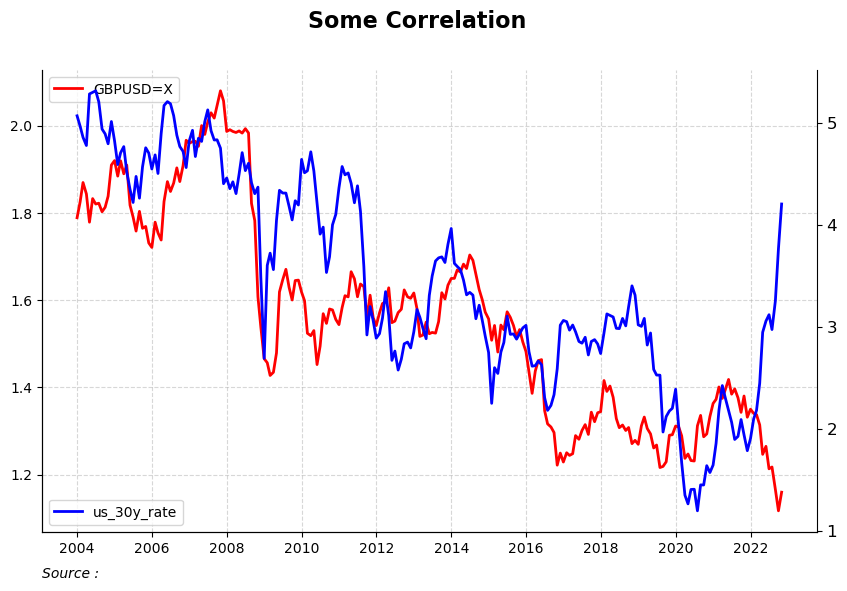

In [55]:
f, ax = plt.subplots(figsize = (10, 6))
f.suptitle('Some Correlation', fontsize = 16, fontweight = 'bold')

ax.plot(chart.index, chart.iloc[:, 0], lw = 2, color = 'red', label = chart.columns[0])
ax2 = ax.twinx()
ax2.plot(chart.index, chart.iloc[:, 1], lw = 2, color = 'blue', label = chart.columns[1])


ax.spines[['top', 'right']].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.grid(alpha = 0.5, ls = '--')
ax.legend(loc = 'upper left')
ax2.legend(loc = 'lower left')
# ax2.invert_yaxis()

void = plt.xticks(fontsize=12)
void = plt.yticks(fontsize=12)

void = ax.text(0, -0.1, 'Source : ',
              fontstyle = 'italic',
              transform = ax.transAxes)